# Reds Hackathon Project - Tufts University
In this notebook, we aim to define various roles for MLB pitchers, and eventually, suggest that some pitchers be used in a role that better suits them. To do this, we used a combination of pitch-level data from Baseball Savant and season-level data from Fangraps.  
This notebook simply contains our code used to draw our concusions. We will expand much more on our methodology and results in the PDF that comes with this code.

##  **1. Imports**
Here, we import the data that we need to start our analysis. We used both Baseball Savant and Fangraphs data for this project, so we need to load in two different datasets as well as some python packages.

In [ ]:
import numpy as np
import pandas as pd
import math

In [ ]:
# mount drive to access .csv files
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
#Load in data

#Grab Fangraphs data
data1 = pd.read_csv('./drive/MyDrive/RedsHackathon/fangraphs_season_level.csv')

#Grab savant data
data2 = pd.read_csv('./drive/MyDrive/RedsHackathon/pitcher_level_data_bs.csv')

## **2. Data Manipulation**
To proceed with our project, we needed to create some new statistics to make sure that we had all the information we needed. This involves mainpulations of our data, which are nexplained below.
### Creating new role column and add to ID

Fangraphs data is broken up by year and role, meaning that a pitcher who appears as a starter and a reliever in one year will account for two different roles in the dataset. To facilitate merging of our data, we needed to modify pitcher ID values to include role and year.

To help us easily get numerical representations of pitcher handedness and whether a pitcher was a starter or relievers, we also created a 0-1 column for whether the pitcher throws right or left handed.

In [ ]:
# Get 0-1 value for whether player was a righty
data1['righty'] = np.where(data1['Throws'] == 'R', 1, 0)

In [ ]:
# Get 0-1 value for whether player was a starter or relievers
data1['sp_indicator'] = np.where(data1['Role'] == 'SP', 1, 0)

In [ ]:
# Modify ID column
data1['pitcher_ID'] = data1['MLBAMID'].astype(str) + data1['Season'].astype(str) + data1['sp_indicator'].astype(str)
data1['pitcher_ID'] = pd.to_numeric(data1["pitcher_ID"], errors='coerce', downcast='integer')

Finally, we merge our dataframes on pitcher ID, using an inner join so as not to include any pitchers in one dataframe but not the other.

In [ ]:
data = pd.merge(data1, data2, on= 'pitcher_ID', how ='inner')

### Creating New Stats
We know wanted to create some new stats that we could feed into our model to determine how many classes of pitchers we have.

In [ ]:
# Create per game stats to normalize for appearances
data['IP/G'] = data['IP'] / data['G']
data['pitches/G'] = data['Pitches'] / data['G']
data['TBF/G'] = data['TBF'] / data['G']

# Create pitches/PA
data['P/PA'] = data['Pitches'] / data['TBF']

# Create platoon advantage percentage
data['platoon_adv_%'] = data['platoon_advantage']/data['TBF']

### Creating Fastball, offspeed and breaking ball stuff+
One thing we wanted to measure is a pitcher's pitch quality for three different types of pitches: fastballs, breaking balls and offspeed pitches.   To perform operations on our whole dataframe, however, we needed to manipulate our data a bit to consider the fact that many pitchers don't throw specific pitches.
#### Pitch percentages
We chose to fill N/A values for pitch percentages with 0, simply to make mathematical computations easier.
#### Stuff+ ratings
We chose to fill N/A values for stuff+ of pitches with the 20th percentile value for stuff plus in that category. The reason we chose to do this is because we later use stuff+ as part of our model to predict what role pitchers should have, and using N/A values would make our model unusable. We decided on the 20th percentile because we felt it struck a fair balance between asisgning a pitcher a 0 for their stuff+ would be very harsh in our model, but we didn't want to reward them too much, so we felt 20th percentile was a good medium.

In [ ]:
# Fill columns we may need that have N/A Values
columns_to_replace_nan = ['FA_pct_sc', 'FC_pct_sc', 'SI_pct_sc', 'FS_pct_sc',
                          'FO_pct_sc', 'SL_pct_sc', 'CU_pct_sc', 'SC_pct_sc',
                          'KC_pct_sc', 'KN_pct_sc', 'EP_pct_sc', 'CH_pct_sc']
data[columns_to_replace_nan] = data[columns_to_replace_nan].fillna(0)

In [ ]:
#columns to replace when no stuff plus exists, replacing with 20th percentile stuff plus
columns_to_replace_np = ['Stf_plus_FA', 'Stf_plus_FC', 'Stf_plus_SI', 'Stf_plus_FS',
                          'Stf_plus_FO', 'Stf_plus_SL', 'Stf_plus_CU', 'Stf_plus_KC',
                          'Stf_plus_CH']

data[columns_to_replace_np] = data[columns_to_replace_np].fillna(0)


In [ ]:
#get percentages for breaking balls, offspeed and fastballs
data['FB%'] = data['FA_pct_sc'] + data['FC_pct_sc'] + data['SI_pct_sc']
data['Breaking%'] = data['SL_pct_sc'] + data['CU_pct_sc'] + data['KC_pct_sc'] + data['KN_pct_sc']
data['Offspeed%'] = data['EP_pct_sc'] + data['CH_pct_sc'] + data['SC_pct_sc'] + data['FS_pct_sc'] + data['FO_pct_sc']
data['FB_stuff+'] = data[['Stf_plus_FA', 'Stf_plus_FC', 'Stf_plus_SI']].max(axis=1)
data['Breaking_stuff+'] = data[['Stf_plus_SL', 'Stf_plus_CU', 'Stf_plus_KC']].max(axis=1)
data['Offspeed_stuff+'] = data[['Stf_plus_CH', 'Stf_plus_FS', 'Stf_plus_FO']].max(axis=1)

In [ ]:
#columns to replace when no stuff plus exists, replacing with 20th percentile stuff plus
columns_to_replace_1 = ['FB_stuff+', 'Breaking_stuff+', 'Offspeed_stuff+']

percentiles_20 = data[data[columns_to_replace_1] != 0][columns_to_replace_1].quantile(0.20)

for column in columns_to_replace_1:
    zero_mask = data[column] == 0
    data.loc[zero_mask, column] = percentiles_20[column]

In [ ]:
data[data['Name'] == 'Graham Ashcraft']['Offspeed_stuff+']

2716    63.266667
2971    66.314816
Name: Offspeed_stuff+, dtype: float64

### Creating platoon+
platoon+ is a stat that we created to make sure that we normalize platoon advantage percentage. The idea of the stat is to make sure we account for the fact there are less lefty hitters in the league. If we want to ask ourselves how pitcher roles involve platoon splits, we have to ensure that we consider a pitcher's usage in context: a lefty specialist may only face 50% lefties, where a righty specialist would likely face more.

In [ ]:
righty_relief = data[(data['Throws'] == 'R') & (data['sp_indicator'] == 0) & (data['G'] >= 10)]
lefty_relief = data[(data['Throws'] == 'L') & (data['sp_indicator'] == 0) & (data['G'] >= 10)]

righty_sd = righty_relief['platoon_adv_%'].std()
lefty_sd = lefty_relief['platoon_adv_%'].std()
righty_mean = righty_relief['platoon_adv_%'].mean()
lefty_mean = lefty_relief['platoon_adv_%'].mean()

In [ ]:
'''From 2021-2023, 59% of plate appearances with righty relief pitchers had
righty hitters and that number was 38% for lefty pitchers and batters. The
standard deviation for these numbers were 0.0619 and 0.0722, respectively'''

def normalize_platoon_adv(row):
    if row['Throws'] == 'L':
        return (row['platoon_adv_%'] / lefty_mean)* 100
    else:
        return (row['platoon_adv_%'] / righty_mean) * 100


In [ ]:
#add platoon+ into our dataframe
data['platoon+'] = data.apply(normalize_platoon_adv, axis=1)

### Normalizing columns
Throughout this notebook, we need to normalize some columns to have a mean of 100 in order to ensure that we weight each column equally in our calculations. We define our function at this point to ensure that it can be run at any point in our notebook.


In [ ]:
# Normalization function for df columns using Z score
def normalize_to_mean(column):
    mean = column.mean()
    #std = column.std()
    return (column/mean) * 100

## **2. Elbow method / K-Means clustering**
Now, we use the elbow method to find our how many classes there are. The [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) is an algorithm by which the optimal value of k is chosen as a precursor to k-means clustering. Every value of k from, in this case, 1-9 will be tested, and distortion will be measured to assess how far points are from their centroids on average. The idea is to pick the k that appears to be the "elbow" of the resulting line graph as the optimal k.  
After running the elbow method to determine k, we will use k-means clustering to separate our pitchers into different categories. K-means clustering is an unsupervised learning algorithm by which a value k for the number of clusters is taken as input, and the algorithm separates the data into that number of classes based on that input.

### Elbow method for starters
Here, we perform the elbow method on just starting pitchers.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
#Filter out relief pitchers
starter_data = data[data['sp_indicator'] == 1]

In [ ]:
#determine features that will be inputs to our KMeans model
elbow_features_starters = ['TBF/G','exLI']

In [ ]:
#Filter our players with less than 5 games appeared in
starter_data_short = starter_data[starter_data['G'] >= 5]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

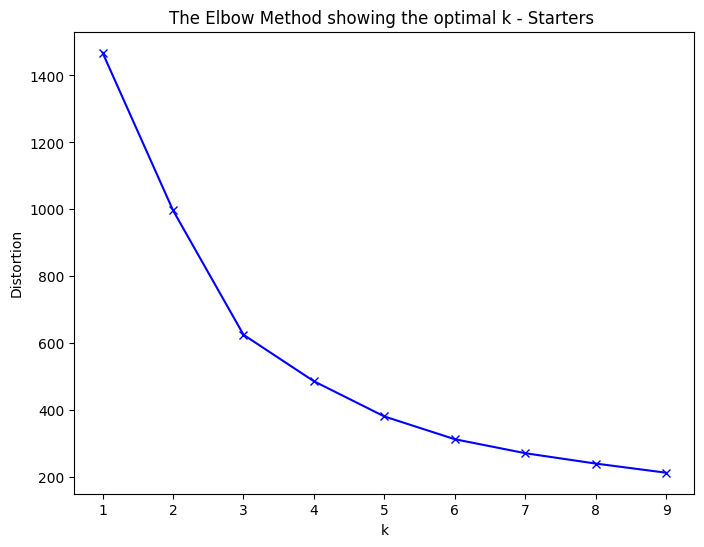

In [ ]:
#Get values for input to elbow method
elbow_input = starter_data_short.loc[:, elbow_features_starters].values

#scale features
scaler = StandardScaler()
elbow_input_scaled = scaler.fit_transform(elbow_input)

#create empty list of distortion values
distortions = []
K = range(1,10)
#run Kmeans with eak possible k, measuring distortion
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(elbow_input_scaled)
    distortions.append(kmeanModel.inertia_)

#plot result
plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k - Starters ')
plt.show()

The elbow method appears to show three categories for starting pitchers.

## K-means clustering (Starters)
We now use KMeans clustering, which is an unserpervised machine learning algorithm which sorts our players into groups, with k = 3.

In [ ]:
NUM_CLUSTERS = 3
kmeans = KMeans(n_clusters = NUM_CLUSTERS, n_init='auto')
y_kmeans = kmeans.fit_predict(elbow_input_scaled)
starter_data_short['category'] = list(y_kmeans)

<ipython-input-131-2453eff1efb7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  starter_data_short['category'] = list(y_kmeans)


We have now separated our data into categories. We wanted to take a look at what each category is in order to get a better sense of what role each category represents.

In [ ]:
grouped_starter_data = starter_data_short.groupby(by = ['category']).mean()
grouped_starter_data.head(7)[['TBF/G', 'righty', 'gmLI', 'platoon+', 'FA_pct', 'exLI', 'ERA']].round(2)

<ipython-input-132-4e80999db7a1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_starter_data = starter_data_short.groupby(by = ['category']).mean()


,TBF/G,righty,gmLI,platoon+,FA_pct,exLI,ERA
category,,,,,,,
0,21.47,0.71,0.87,79.32,0.49,0.91,4.84
1,22.02,0.69,0.87,77.48,0.48,1.24,4.30
2,8.52,0.68,0.87,93.20,0.49,0.97,4.66


It appears that our three categories representstarters with a shorter leash, openers, and starters longer leash respectively. **Note:** Re-running our code will occasionally re-arrange these categories into different numbers, but the actual content of the categories will be the same.  
We now wanted to check out the means of these categories when it comes to underlying metrics, namely, stuff and command.

In [ ]:
category_means_starters = starter_data_short.groupby(by = ['category']).mean()
category_means_starters.head()[['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']].round(2)

<ipython-input-133-b1452e5be703>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  category_means_starters = starter_data_short.groupby(by = ['category']).mean()


,Breaking_stuff+,FB_stuff+,Offspeed_stuff+,botCmd,FAv
category,,,,,
0,105.83,97.31,81.04,53.49,93.11
1,109.56,99.19,83.45,54.13,93.06
2,112.70,100.83,79.16,54.70,93.90


## Relievers

This section repeats the same process we used for starters, but with relievers.

In [ ]:
#Get data for only relief pitchers
reliever_data = data[data['sp_indicator'] == 0]

In [ ]:
#filter out pitchers with less than 10 appearances
reliever_data_short = reliever_data[reliever_data['G'] >= 10]

Here, we decided to use one more feature for our reliever elbow method input. The reason we included platoon+ is because some relievers are specialists, meaning they are often used in situations with an advantageous platoon situation for them. We wanted to factor this in for relievers, but not for starters, as starters are expected to face an entire lineup. Introducing unnecessary metrics can confuse the elbow method, so we wanted to only use metrics essential to determining roles.


In [ ]:
#Get features for elbow method
elbow_features_relievers = ['TBF/G', 'platoon+','pLI']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

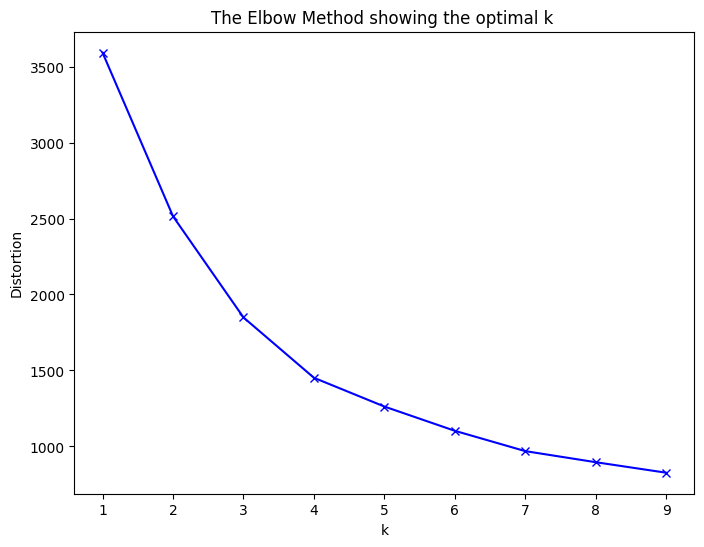

In [ ]:
#get input to elbow method for relievers
elbow_input_relievers = reliever_data_short.loc[:, elbow_features_relievers].values

scaler = StandardScaler()
elbow_input_scaled_relievers = scaler.fit_transform(elbow_input_relievers)

#create empty list of distortion
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(elbow_input_scaled_relievers)
    distortions.append(kmeanModel.inertia_)


plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k ')
plt.show()

The elbow here is certainly less clear, but we decided to go forward with k = 4. One could make an argument the elbow should be elsewhere, but after some discussion, we decided on using 4.  
## K-Means clustering (Relievers)
We wanted to separate pitchers into clusters
We now run k-means clustering with k = 4.  


In [ ]:
NUM_CLUSTERS = 4
kmeans = KMeans(n_clusters = NUM_CLUSTERS, n_init='auto')
y_kmeans = kmeans.fit_predict(elbow_input_scaled_relievers)
reliever_data_short['category'] = list(y_kmeans)

#add 3 to all categories to differentiate from starter categories
reliever_data_short['category'] = reliever_data_short['category'] + 3

<ipython-input-138-414b19798b5a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reliever_data_short['category'] = list(y_kmeans)
<ipython-input-138-414b19798b5a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reliever_data_short['category'] = reliever_data_short['category'] + 3


We now again identify our categories to understand what our roles represent.

In [ ]:
grouped_reliever_data = reliever_data_short.groupby(by = ['category']).mean()
grouped_reliever_data.head(6)[['TBF/G', 'righty', 'gmLI', 'platoon+', 'FB%', 'Breaking%', 'Offspeed%']].round(2)

<ipython-input-139-214981697d51>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_reliever_data = reliever_data_short.groupby(by = ['category']).mean()


,TBF/G,righty,gmLI,platoon+,FB%,Breaking%,Offspeed%
category,,,,,,,
3,4.13,0.77,1.46,91.96,0.58,0.32,0.10
4,9.12,0.72,0.72,97.17,0.56,0.30,0.15
5,5.23,0.75,0.75,95.45,0.58,0.31,0.12
6,4.33,0.67,1.06,113.33,0.57,0.34,0.09


Our four categories appear to be specialists, high leverage relievers, low leverage short relievers and long relievers/mop up guys. Again, note that the numbers assosciated with these categories may change, but the actual category definitions won't change.  
Again, we wanted to check the means of these categories to better understand them based on underlying metrics.

In [ ]:
category_means_relievers = reliever_data_short.groupby(by = ['category']).mean()
category_means_relievers.head()[['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']].round(2)

<ipython-input-140-b09f896363ba>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  category_means_relievers = reliever_data_short.groupby(by = ['category']).mean()


,Breaking_stuff+,FB_stuff+,Offspeed_stuff+,botCmd,FAv
category,,,,,
3,117.67,111.13,81.97,50.54,95.27
4,103.29,97.21,79.63,52.23,93.11
5,110.09,101.25,78.46,48.40,93.84
6,108.92,103.78,79.00,49.96,93.85


## **3. Using euclidean distance  to determine best category**
Now that we have underlying metrics for pitchers, we wanted to find a way to determine how pitchers should ideally be used. To do this, we took the euclidean distance from each pitcher's metrics in categories related to their **underlying** numbers, including stuff on fastballs, breaking balls and offspeed pitches, as well as command and average fastball velocity, to the means values of those metric in each of our categories.

We first define a function to compute the distance of any pitcher in our dataframe to the average value of each category. This function will return an array of distances, and will tell us how much a pitcher's profile matches the average profile of a pitcher in each category.

In [ ]:
def compute_distance(row):

    #isolate metrics we want to consider
    player_metrics = row[['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']]
    distances = {}
    #iterate through all values in category means DataFrame
    for category, mean_values in category_means.iterrows():

        category_metrics = mean_values[['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']]

        #get distances from player metrics to category means
        distance = np.sqrt(np.sum((player_metrics - category_metrics) ** 2))

        distances[category] = distance

    return distances


Now, we can proceed computing our distances.

## Combining starters and reliever categories to get all categories

Earlier, we used the elbow method to find our starter and reliever categories. However, we didn't want to only have relievers be put into relief roles, and likewise for starters. Thus, we combine the starters and relievers into one larger DataFrame to make sure we allow each pitcher's distance from each role to be computed.


In [ ]:
#Combine reliever and Starter data
filtered_data = starter_data_short.append(reliever_data_short, ignore_index=True)

<ipython-input-142-14e74d57d330>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = starter_data_short.append(reliever_data_short, ignore_index=True)


## Identifying categories
We now wanted to get a feel for what roles certain categories represent. To do this, we group some data together and print the resulting DataFrame. In the same way as earlier in the notebook, we have three starting pitcher categories as well as four relief categories.  

In [ ]:
grouped_all_categories = grouped_starter_data.append(grouped_reliever_data, ignore_index=True)
grouped_all_categories[['TBF/G', 'righty', 'gmLI', 'platoon+', 'FA_pct', 'exLI', 'ERA', 'sp_indicator']].round(2)

<ipython-input-143-37e87cee08a2>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_all_categories = grouped_starter_data.append(grouped_reliever_data, ignore_index=True)


,TBF/G,righty,gmLI,platoon+,FA_pct,exLI,ERA,sp_indicator
0,21.47,0.71,0.87,79.32,0.49,0.91,4.84,1.0
1,22.02,0.69,0.87,77.48,0.48,1.24,4.30,1.0
2,8.52,0.68,0.87,93.20,0.49,0.97,4.66,1.0
3,4.13,0.77,1.46,91.96,0.52,1.54,3.40,0.0
4,9.12,0.72,0.72,97.17,0.49,0.80,4.83,0.0
5,5.23,0.75,0.75,95.45,0.51,0.84,4.82,0.0
6,4.33,0.67,1.06,113.33,0.52,1.07,4.25,0.0


We now normalize the columns we compute distance based on. The reason for this is that some of these columns are on different scales. For instance, a 100 breaking_stuff+ is average, but a 100 average fastball velocity is outstanding. We can easily normalize using our above normalization function.

In [ ]:
columns_to_normalize = ['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']
filtered_data[columns_to_normalize] = filtered_data[columns_to_normalize].apply(normalize_to_mean)

In [ ]:
#Combine reliever and starter category means
category_means = category_means_starters.append(category_means_relievers)
category_means[['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']].round(2)

<ipython-input-145-beb56fb6d158>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  category_means = category_means_starters.append(category_means_relievers)


,Breaking_stuff+,FB_stuff+,Offspeed_stuff+,botCmd,FAv
category,,,,,
0,105.83,97.31,81.04,53.49,93.11
1,109.56,99.19,83.45,54.13,93.06
2,112.70,100.83,79.16,54.70,93.90
3,117.67,111.13,81.97,50.54,95.27
4,103.29,97.21,79.63,52.23,93.11
5,110.09,101.25,78.46,48.40,93.84
6,108.92,103.78,79.00,49.96,93.85


We now proceed to computing our distance metric for every pitcher to each category. Below is a demonstration of what the DataFrame looks like. Querying for any player will show their distance to each category.

In [ ]:
distances_all = filtered_data.apply(compute_distance, axis=1, result_type='expand')


In [ ]:
distances_all[['NameASCII', 'category', 'Season', 'sp_indicator', 'Team', 'MLBAMID']] = filtered_data[['NameASCII', 'category', 'Season', 'sp_indicator', 'Team', 'MLBAMID']]

In [ ]:
distances_all.head().round(2)

,0,1,2,3,4,5,6,NameASCII,category,Season,sp_indicator,Team,MLBAMID
0,83.27,82.43,85.94,91.09,84.64,90.18,89.03,Zack Greinke,1,2021,1,HOU,425844
1,67.51,65.22,65.63,68.42,69.77,72.02,70.55,Adam Wainwright,1,2021,1,STL,425794
2,50.23,47.75,47.54,49.65,52.51,53.94,52.28,Corey Kluber,1,2021,1,NYY,446372
3,61.75,61.35,62.77,67.56,62.78,67.81,65.81,Lance Lynn,1,2021,1,CHW,458681
4,71.00,69.10,70.24,71.43,72.70,75.57,73.36,Max Scherzer,0,2021,1,- - -,453286


## More normalization
One problem we ran into was that players who had very average metrics across the board appeared the closest to every single category. For instance, a guy with 100 stuff+ for fastball, breaking ball and off speed pitches would appear to be a good fit for every category.  
To remedy this, we chose to add up a player's total distance and represent each distance as a percentage of the sum of all their distances. Essentially, we separate our whether a pitcher is good, average or below average, and simply look at which category they are closest to.

In [ ]:
#normalize distance columns to fix any scaling issues
columns_to_normalize = [0,1,2,3,4,5,6]
distances_all[columns_to_normalize] = distances_all[columns_to_normalize].apply(normalize_to_mean)

In [ ]:
#find total distance for each player
distances_all['distances_total'] = distances_all[0] + distances_all[1] + distances_all[2] + distances_all[3] + distances_all[4] + distances_all[5] + distances_all[6]

In [ ]:
#Get score as a percentage of total distance
distances_all['0_score'] = distances_all[0].div(distances_all['distances_total'])
distances_all['1_score'] = distances_all[1].div(distances_all['distances_total'])
distances_all['2_score'] = distances_all[2].div(distances_all['distances_total'])
distances_all['3_score'] = distances_all[3].div(distances_all['distances_total'])
distances_all['4_score'] = distances_all[4].div(distances_all['distances_total'])
distances_all['5_score'] = distances_all[5].div(distances_all['distances_total'])
distances_all['6_score'] = distances_all[6].div(distances_all['distances_total'])

#assign closest category based on minimum of distance scores
distances_all['closest_category'] = distances_all[['0_score','1_score','2_score','3_score','4_score','5_score','6_score']].idxmin(axis=1)

## **4. Results and Plots**
The prompt asked us to identify two pitchers who could benefit from a change in role. We expand on this in our submitted PDF, but we chose Reds SP Graham Ashcraft and reliever Javy Guerra, who will be playing for the Hanshin Tigers of the NPB this coming season.
We suggest that both pitchers move into high leverage relief roles, with Ashcraft having started this past season and Guerra occupying a low-leverage middle relief role with some multi-inning appearances.  
Of all players, Guerra was the closest fit to our high-leverage relief category, and when we just considered starting pitchers, Ashcraft was one of the starters who best profiled as a high leverage reliever.   
Below is code we used to generate some plots that support our notebook, as well as a csv file we exported to continue plotting in R.

In [ ]:
#isolate high leverage relievers
high_leverage_relievers = filtered_data[filtered_data['category'] == 4]

#Get data from seasons of interest for Javy Guerra and Graham Ashcraft
guerra = filtered_data[(filtered_data['MLBAMID'] == 642770) & (filtered_data['Season'] == 2023) & (filtered_data['sp_indicator'] == 0)]
ashcraft = filtered_data[(filtered_data['MLBAMID'] == 668933) & (filtered_data['Season'] == 2023)]

high_leverage_relievers = high_leverage_relievers.append([guerra, ashcraft])

<ipython-input-152-225a53881d3a>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_leverage_relievers = high_leverage_relievers.append([guerra, ashcraft])


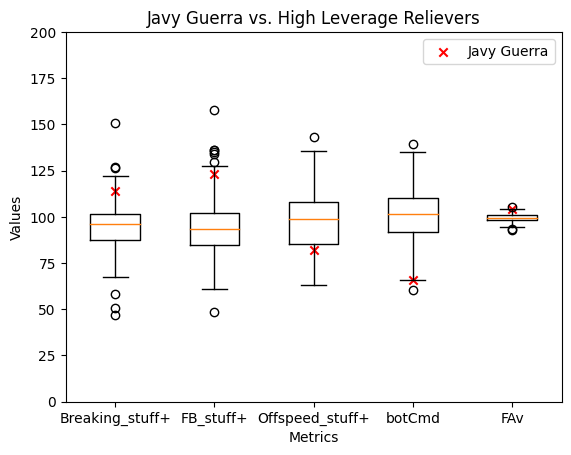

In [ ]:
short_data = high_leverage_relievers[['Name', 'Season', 'Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']].dropna()

# Create a boxplot
plt.boxplot(short_data[['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']])

# Isolate Javy Guerra
JG_row = short_data[(short_data['Name'] == 'Javy Guerra') & (short_data['Season'] == 2023)]

# Extract Guerra's values
JG_values = JG_row[['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']].values.flatten()

# Use scatter plot to plot metrics
plt.scatter([1, 2, 3, 4, 5], JG_values, color='red', marker='x', label='Javy Guerra')


# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Javy Guerra vs. High Leverage Relievers')
plt.ylim(0, 200)

plt.xticks([1, 2, 3, 4, 5], ['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv'])
plt.legend()

# Show the plot
plt.show()


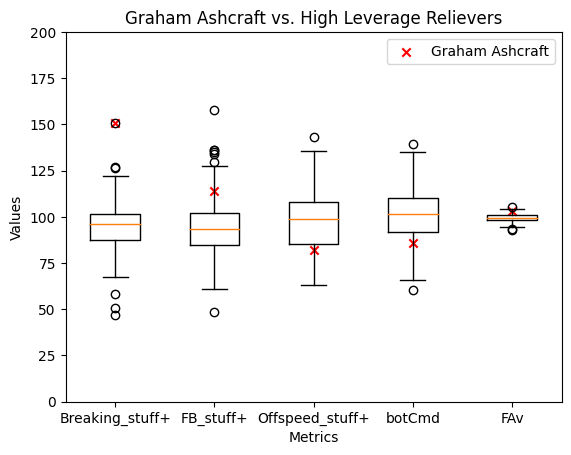

In [ ]:
# Create a boxplot
plt.boxplot(short_data[['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']])

# Isolate Graham Ashcraft
GA_row = short_data[short_data['Name'] == 'Graham Ashcraft']

# Extract Ashcraft's values
GA_values = GA_row[['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv']].values.flatten()

# Use scatter plot to plot metrics

plt.scatter([1, 2, 3, 4, 5], GA_values, color='red', marker='x', label='Graham Ashcraft')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Graham Ashcraft vs. High Leverage Relievers')
plt.ylim(0, 200)

plt.xticks([1, 2, 3, 4, 5], ['Breaking_stuff+', 'FB_stuff+', 'Offspeed_stuff+', 'botCmd', 'FAv'])
plt.legend()

# Show the plot
plt.show()


In [ ]:
guerra

,PlayerId,MLBAMID,Name,NameASCII,Throws,Season,Age,Team,Role,G,...,P/PA,platoon_adv_%,FB%,Breaking%,Offspeed%,FB_stuff+,Breaking_stuff+,Offspeed_stuff+,platoon+,category
1443,17292,642770,Javy Guerra,Javy Guerra,R,2023,27,- - -,RP,15,...,3.704545,0.545455,0.677,0.3231,0.0,123.110297,113.735483,82.25926,93.110344,5


In [ ]:
ashcraft

,PlayerId,MLBAMID,Name,NameASCII,Throws,Season,Age,Team,Role,G,...,P/PA,platoon_adv_%,FB%,Breaking%,Offspeed%,FB_stuff+,Breaking_stuff+,Offspeed_stuff+,platoon+,category
494,27552,668933,Graham Ashcraft,Graham Ashcraft,R,2023,25,CIN,SP,26,...,3.727564,0.524038,0.626,0.3741,0.0,114.01569,150.660735,82.25926,89.454569,1


Now, we export our distances to a .csv for plotting in R.

In [ ]:
distances_all.to_csv('./drive/MyDrive/RedsHackathon/reliever_categories4.csv')

## **5. Acknowledgements**
We would like to thank Fangraphs and Baseball Savant for providing the data used for this project. We also want to thank the staff with the Reds for providing us with clean and usable datasets.
We used a lot of online resources throughout this project, including StackOverflow, ChatGPT, GeeksForGeeks and SKLearn documentation.  
